In [1]:
import sys
import os
from pathlib import Path
import mlx.core as mx

# Get the src directory path relative to notebook location
notebook_dir = Path.cwd()
src_dir = notebook_dir.parent
sys.path.append(str(src_dir))

# Import new optimizers
from src.core.optimizers import AdamOptimizer
from src.core.collinearity_scorer_batch import BatchCollinearityScorer
from src.utilities.load_flows import load_flows
from src.core.flow_filter import FlowFilterSample
from src.utilities.ground_truth import read_ground_truth_pixels

In [ ]:
# Helper function to replace adam_optimize_single
def adam_optimize_single(single_flow, starting_point, **kwargs):
    """Wrapper function for notebook compatibility"""
    from src.core.collinearity_scorer_batch import BatchCollinearityScorer
    
    estimator = BatchCollinearityScorer(
        single_flow.shape[1], single_flow.shape[0], 
        use_max_distance=False, use_reoptimization=False
    )
    
    optimizer = AdamOptimizer(**kwargs)
    return optimizer.optimize_single(estimator, single_flow, starting_point)


In [2]:
video_idx = 3
flows = load_flows(video_idx, use_compressed=True)
labels = read_ground_truth_pixels(video_idx)

📂 Chargement flows vidéo 3 (NPZ (compressé)) - 2.4 GB
✅ Flows chargés depuis NPZ: (1199, 874, 1164, 2) (float16)


In [20]:
frame_idx = 0
flow = flows[frame_idx]
frame_center = (flow.shape[0]//2, flow.shape[1]//2)
label = labels[frame_idx]
ffilter = FlowFilterSample()
ffilter.config['filtering']['norm']['is_used'] = True
ffilter.config['filtering']['norm']['min_threshold'] = 13
ffilter.config['filtering']['colinearity']['is_used'] = True
ffilter.config['filtering']['colinearity']['min_threshold'] = 0.96
fflow = ffilter.filter(flow)

In [21]:
starting_point = mx.array((flow.shape[1]//2, flow.shape[0]//2))
pred_adam = adam_optimize_single(fflow, starting_point, plateau_patience=10)
pred_adam

array([683.413, 359.866], dtype=float32)

In [22]:
vpe = BatchCollinearityScorer(flow.shape[1], flow.shape[0], use_max_distance=False, use_reoptimization=False)
pred_lgbt = vpe.find_vanishing_point_lbfgsb(fflow, visualize=False)
pred_lgbt

(np.float64(582.0), np.float64(437.0))

In [23]:
vpe.colin_score(fflow, pred_lgbt)

array(0.00474359, dtype=float32)

In [24]:
vpe.colin_score(fflow, pred_adam)

array(0.00478066, dtype=float32)

In [25]:
vpe.colin_score(fflow, label)

array(0.00475843, dtype=float32)

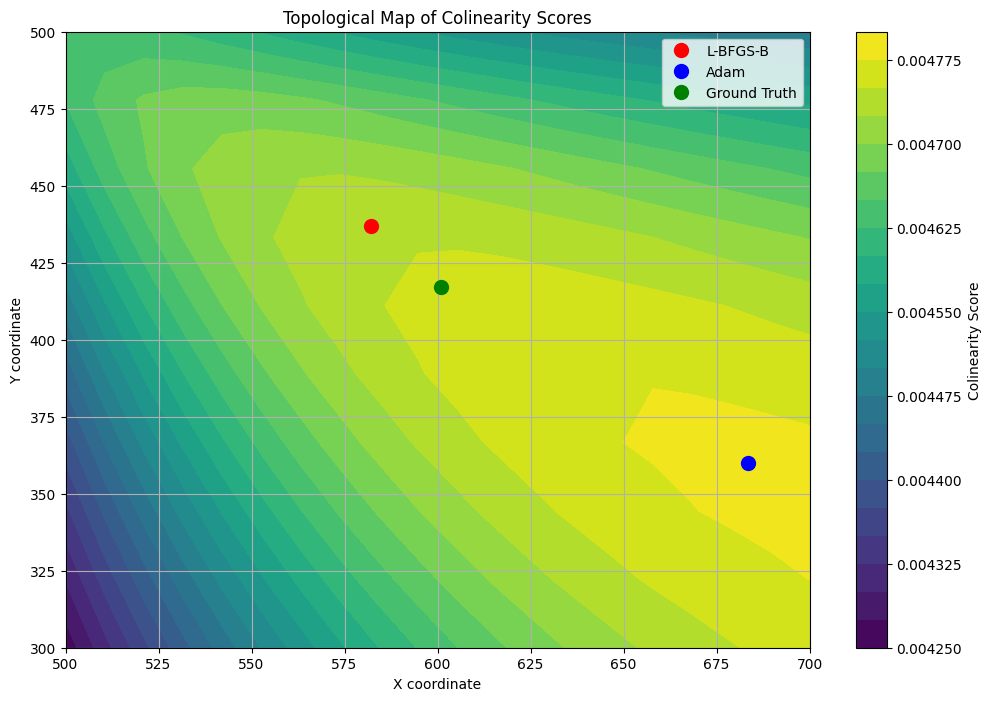

In [26]:
import numpy as np
import matplotlib.pyplot as plt
# Create a grid of points around the image center
x = np.linspace(500, 700, 20)
y = np.linspace(300, 500, 10)
X, Y = np.meshgrid(x, y)

# Calculate colinearity scores for each point
Z = np.zeros_like(X)
for i in range(len(x)):
    for j in range(len(y)):
        Z[j,i] = vpe.colin_score(fflow, (X[j,i], Y[j,i]))

# Create the plot
plt.figure(figsize=(12, 8))
contour = plt.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar(contour, label='Colinearity Score')

# Plot the three points
plt.plot(pred_lgbt[0], pred_lgbt[1], 'ro', label='L-BFGS-B', markersize=10)
plt.plot(pred_adam[0], pred_adam[1], 'bo', label='Adam', markersize=10)
plt.plot(label[0], label[1], 'go', label='Ground Truth', markersize=10)

plt.title('Topological Map of Colinearity Scores')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
# ==========================================
# CHOISIR LA FRAME ICI
# ==========================================
frame_idx = 100  # Changer cette valeur pour tester différentes frames

# ==========================================
# TRAITEMENT AUTOMATIQUE
# ==========================================
print(f"Analyse de la frame {frame_idx}")

# Charger flow et label pour cette frame (sécurisé)
flow = flows[frame_idx]
if frame_idx < len(labels):
    label = labels[frame_idx]
else:
    print(f"Attention: pas de label pour frame {frame_idx}, utilisation du centre")
    label = (flow.shape[1]//2, flow.shape[0]//2)

print(f"Flow shape: {flow.shape}")
print(f"Ground truth label: {label}")

# Filtrer le flow
ffilter = FlowFilterSample()
ffilter.config['filtering']['norm']['is_used'] = True
ffilter.config['filtering']['norm']['min_threshold'] = 13
ffilter.config['filtering']['colinearity']['is_used'] = True
ffilter.config['filtering']['colinearity']['min_threshold'] = 0.7
fflow = ffilter.filter(flow)

# Optimisation Adam
starting_point = mx.array((flow.shape[1]//2, flow.shape[0]//2))
pred_adam = adam_optimize_single(fflow, starting_point, plateau_patience=10)
print(f"Adam result: ({pred_adam[0]:.1f}, {pred_adam[1]:.1f})")

# Optimisation L-BFGS-B
vpe = BatchCollinearityScorer(flow.shape[1], flow.shape[0], use_max_distance=False, use_reoptimization=False)
pred_lgbt = vpe.find_vanishing_point_lbfgsb(fflow, visualize=False)
print(f"L-BFGS-B result: ({pred_lgbt[0]:.1f}, {pred_lgbt[1]:.1f})")

# Centre de l'image
center_point = (flow.shape[1]//2, flow.shape[0]//2)
print(f"Center point: {center_point}")

# Calcul des scores
score_adam = vpe.colin_score(fflow, pred_adam)
score_lgbt = vpe.colin_score(fflow, pred_lgbt)
score_label = vpe.colin_score(fflow, label)
score_center = vpe.colin_score(fflow, center_point)

print(f"\n=== SCORES DE COLINEARITE ===")
print(f"Adam:        {score_adam:.6f}")
print(f"L-BFGS-B:    {score_lgbt:.6f}")
print(f"Ground Truth: {score_label:.6f}")
print(f"Center:      {score_center:.6f}")

# ==========================================
# VISUALISATION TOPOGRAPHIQUE
# ==========================================
import numpy as np
import matplotlib.pyplot as plt

# Zone sur toute l'image
x_min = 0
x_max = flow.shape[1]  # Largeur complète
y_min = 0
y_max = flow.shape[0]  # Hauteur complète

print(f"\nZone topographique: X=[{x_min:.0f}, {x_max:.0f}], Y=[{y_min:.0f}, {y_max:.0f}]")
print(f"Résolution de l'image: {flow.shape[1]} x {flow.shape[0]}")

# Grille de calcul (plus sparse pour toute l'image)
x = np.linspace(x_min, x_max, 100)
y = np.linspace(y_min, y_max, 100)
X, Y = np.meshgrid(x, y)

print("Calcul du landscape...")
Z = np.zeros_like(X)
for i in range(len(x)):
    for j in range(len(y)):
        # Convertir en float32 pour MLX
        point = (float(X[j,i]), float(Y[j,i]))
        Z[j,i] = vpe.colin_score(fflow, point)

# Visualisation interactive avec Plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = go.Figure()

# Heatmap au lieu de contours pour un meilleur rescaling
fig.add_trace(go.Heatmap(
    x=x,
    y=y, 
    z=Z,
    colorscale='Viridis',
    showscale=True,
    colorbar=dict(title="Colinearity Score"),
    hovertemplate='X: %{x:.1f}<br>Y: %{y:.1f}<br>Score: %{z:.6f}<extra></extra>',
    zauto=True,  # 🎯 RESCALING FONCTIONNEL avec heatmap !
    zsmooth='best'  # Lissage pour une meilleure apparence
))

# Ajouter des contours par-dessus pour les lignes de niveau
fig.add_trace(go.Contour(
    x=x,
    y=y, 
    z=Z,
    showscale=False,  # Pas de colorbar supplémentaire
    contours=dict(
        showlines=True,
        coloring='lines',  # Juste les lignes, pas de remplissage
        start=Z.min(),
        end=Z.max(),
        size=(Z.max() - Z.min()) / 15  # 15 niveaux
    ),
    line=dict(color='white', width=1),
    hoverinfo='skip'  # Pas de hover sur les lignes
))

# Points avec décalage pour éviter la superposition
offset = 3  # Décalage en pixels pour séparer les points

fig.add_trace(go.Scatter(
    x=[pred_lgbt[0] - offset], y=[pred_lgbt[1] - offset], 
    mode='markers+text',
    marker=dict(color='red', size=20, symbol='circle', line=dict(color='white', width=3)),
    text=['L-BFGS-B'],
    textposition='top center',
    textfont=dict(color='red', size=12, family='Arial Black'),
    name=f'L-BFGS-B',
    hovertemplate='L-BFGS-B<br>X: %{x:.1f}<br>Y: %{y:.1f}<br>Score: ' + f'{score_lgbt:.6f}<extra></extra>'
))

fig.add_trace(go.Scatter(
    x=[pred_adam[0] + offset], y=[pred_adam[1] - offset], 
    mode='markers+text',
    marker=dict(color='blue', size=20, symbol='circle', line=dict(color='white', width=3)),
    text=['Adam'],
    textposition='top center',
    textfont=dict(color='blue', size=12, family='Arial Black'),
    name=f'Adam',
    hovertemplate='Adam<br>X: %{x:.1f}<br>Y: %{y:.1f}<br>Score: ' + f'{score_adam:.6f}<extra></extra>'
))

fig.add_trace(go.Scatter(
    x=[label[0] - offset], y=[label[1] + offset], 
    mode='markers+text',
    marker=dict(color='green', size=20, symbol='circle', line=dict(color='white', width=3)),
    text=['GT'],
    textposition='bottom center',
    textfont=dict(color='green', size=12, family='Arial Black'),
    name=f'Ground Truth',
    hovertemplate='Ground Truth<br>X: %{x:.1f}<br>Y: %{y:.1f}<br>Score: ' + f'{score_label:.6f}<extra></extra>'
))

fig.add_trace(go.Scatter(
    x=[center_point[0] + offset], y=[center_point[1] + offset], 
    mode='markers+text',
    marker=dict(color='black', size=20, symbol='circle', line=dict(color='white', width=3)),
    text=['Center'],
    textposition='bottom center',
    textfont=dict(color='black', size=12, family='Arial Black'),
    name=f'Center',
    hovertemplate='Center<br>X: %{x:.1f}<br>Y: %{y:.1f}<br>Score: ' + f'{score_center:.6f}<extra></extra>'
))

# Configuration du layout
title_text = f'Interactive Topological Landscape - Frame {frame_idx}<br>' + \
             f'<span style="font-size:12px">L-BFGS-B: {score_lgbt:.6f} | Adam: {score_adam:.6f} | GT: {score_label:.6f} | Center: {score_center:.6f}</span>'

fig.update_layout(
    title=title_text,
    xaxis_title='X coordinate (pixels)',
    yaxis_title='Y coordinate (pixels)',
    width=1000,
    height=800,
    showlegend=True,
    # Inverser l'axe Y pour correspondre aux coordonnées image
    yaxis=dict(autorange='reversed'),
    # Conserver le ratio d'aspect
    yaxis_scaleanchor="x",
    template='plotly_white'
)

# Annotation informative
fig.add_annotation(
    text="🔥 HEATMAP avec rescaling automatique au zoom !",
    xref="paper", yref="paper",
    x=0.02, y=0.98,
    showarrow=False,
    font=dict(size=12, color="darkblue"),
    bgcolor="lightgreen",
    bordercolor="green",
    borderwidth=1
)

# Pas besoin de mise à jour des contours avec la heatmap

fig.show()

print(f"\n🎯 Visualisation interactive avec rescaling automatique !")
print("💡 Fonctionnalités améliorées :")
print("   - 🔍 Zoom: sélection ou molette")
print("   - 🎨 RESCALING AUTO: les couleurs s'adaptent au zoom") 
print("   - 📐 Pan: cliquer-glisser") 
print("   - 🔄 Reset: double-clic")
print("   - 📊 Hover: valeurs précises")
print("   - 📏 Labels de contours: visibles sur les lignes")

print(f"\nVisualisation terminée pour la frame {frame_idx}!")


Analyse de la frame 100
Flow shape: (874, 1164, 2)
Ground truth label: (602, 411)


/Users/hugovaillaud/Documents/code/ibiza_project/calib_challenge/src/flow_filter.py:249: RuntimeWarning:

divide by zero encountered in divide

/Users/hugovaillaud/Documents/code/ibiza_project/calib_challenge/src/flow_filter.py:249: RuntimeWarning:

invalid value encountered in divide



Adam result: (587.2, 413.5)
L-BFGS-B result: (582.0, 437.0)
Center point: (582, 437)

=== SCORES DE COLINEARITE ===
Adam:        0.024247
L-BFGS-B:    0.024201
Ground Truth: 0.024242
Center:      0.024201

Zone topographique: X=[0, 1164], Y=[0, 874]
Résolution de l'image: 1164 x 874
Calcul du landscape...



🎯 Visualisation interactive avec rescaling automatique !
💡 Fonctionnalités améliorées :
   - 🔍 Zoom: sélection ou molette
   - 🎨 RESCALING AUTO: les couleurs s'adaptent au zoom
   - 📐 Pan: cliquer-glisser
   - 🔄 Reset: double-clic
   - 📊 Hover: valeurs précises
   - 📏 Labels de contours: visibles sur les lignes

Visualisation terminée pour la frame 100!


In [23]:
# ==========================================
# VERSION BOKEH AVEC VRAI RESCALING !
# ==========================================

# 🎯 PARAMÈTRES CONFIGURABLES
frame_idx = 100  # Changer le numéro de frame ici
filtering_params = {
    'norm_threshold': 1,
    'colinearity_threshold': 0.8
}

print(f"🎬 Configuration : Frame {frame_idx}")
print(f"🔧 Filtrage : norm>{filtering_params['norm_threshold']}, colin>{filtering_params['colinearity_threshold']}")

# Imports et setup
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColorBar, LinearColorMapper, HoverTool, Slider, CustomJS, ColumnDataSource
from bokeh.layouts import column, row
from bokeh.io import push_notebook
import numpy as np

output_notebook()

# Recalculer avec les nouveaux paramètres
print("🚀 Recalcul avec les paramètres choisis...")

# Charger flow et label
flow = flows[frame_idx]
if frame_idx < len(labels):
    label = labels[frame_idx]
else:
    print(f"⚠️ Pas de label pour frame {frame_idx}, utilisation du centre")
    label = (flow.shape[1]//2, flow.shape[0]//2)

# Filtrer le flow
ffilter = FlowFilterSample()
ffilter.config['filtering']['norm']['is_used'] = True
ffilter.config['filtering']['norm']['min_threshold'] = filtering_params['norm_threshold']
ffilter.config['filtering']['colinearity']['is_used'] = True
ffilter.config['filtering']['colinearity']['min_threshold'] = filtering_params['colinearity_threshold']
fflow = ffilter.filter(flow)

# Optimisations
starting_point = mx.array((flow.shape[1]//2, flow.shape[0]//2))
pred_adam = adam_optimize_single(fflow, starting_point, plateau_patience=10)
vpe = BatchCollinearityScorer(flow.shape[1], flow.shape[0], use_max_distance=False, use_reoptimization=False)
pred_lgbt = vpe.find_vanishing_point_lbfgsb(fflow, visualize=False)
center_point = (flow.shape[1]//2, flow.shape[0]//2)

# Scores
score_adam = vpe.colin_score(fflow, pred_adam)
score_lgbt = vpe.colin_score(fflow, pred_lgbt)
score_label = vpe.colin_score(fflow, label)
score_center = vpe.colin_score(fflow, center_point)

print(f"✅ Résultats Frame {frame_idx}:")
print(f"   Adam: ({float(pred_adam[0]):.1f}, {float(pred_adam[1]):.1f}) score={score_adam:.6f}")
print(f"   L-BFGS-B: ({float(pred_lgbt[0]):.1f}, {float(pred_lgbt[1]):.1f}) score={score_lgbt:.6f}")
print(f"   Ground Truth: {label} score={score_label:.6f}")
print(f"   Center: {center_point} score={score_center:.6f}")

# Calcul du landscape
x_min, x_max = 0, flow.shape[1]
y_min, y_max = 0, flow.shape[0]
x = np.linspace(x_min, x_max, 100)
y = np.linspace(y_min, y_max, 100)
X, Y = np.meshgrid(x, y)

print("📊 Calcul du landscape...")
Z = np.zeros_like(X)
for i in range(len(x)):
    for j in range(len(y)):
        point = (float(X[j,i]), float(Y[j,i]))
        Z[j,i] = vpe.colin_score(fflow, point)

print("🚀 Création de la visualisation Bokeh...")

# Convertir les MLX arrays en numpy/python pour la sérialisation - VRAIES POSITIONS
pred_lgbt_np = (float(pred_lgbt[0]), float(pred_lgbt[1]))
pred_adam_np = (float(pred_adam[0]), float(pred_adam[1]))
label_np = (float(label[0]), float(label[1]))
center_np = (float(center_point[0]), float(center_point[1]))

print(f"✅ Conversion des données - POSITIONS RÉELLES :")
print(f"   L-BFGS-B: {pred_lgbt_np}")
print(f"   Adam: {pred_adam_np}")
print(f"   Ground Truth: {label_np}")
print(f"   Center: {center_np}")

# Vérifier les distances entre points
import numpy as np
dist_lg_center = np.sqrt((pred_lgbt_np[0] - center_np[0])**2 + (pred_lgbt_np[1] - center_np[1])**2)
dist_adam_gt = np.sqrt((pred_adam_np[0] - label_np[0])**2 + (pred_adam_np[1] - label_np[1])**2)
print(f"\n📏 Distances entre points :")
print(f"   L-BFGS-B ↔ Center: {dist_lg_center:.1f} pixels")
print(f"   Adam ↔ Ground Truth: {dist_adam_gt:.1f} pixels")

# Créer la figure Bokeh
p = figure(
    width=900, 
    height=700,
    title=f"Bokeh Interactive Landscape - Frame {frame_idx} (ZOOM + SLIDERS = RESCALING!)",
    x_axis_label="X coordinate (pixels)",
    y_axis_label="Y coordinate (pixels)",
    tools="pan,wheel_zoom,box_zoom,reset,save",
    match_aspect=True
)

# Inverser l'axe Y pour correspondre aux coordonnées image
p.y_range.flipped = True

# Créer le mapper de couleurs
color_mapper = LinearColorMapper(palette="Viridis256", 
                               low=Z.min(), 
                               high=Z.max())

# Préparer l'image pour Bokeh (inverser Y)
z_image = np.flipud(Z)

# Créer la source de données
source = ColumnDataSource(data=dict(image=[z_image]))

# Heatmap avec les données
p.image(image='image', x=0, y=0, dw=flow.shape[1], dh=flow.shape[0], 
        color_mapper=color_mapper, alpha=0.9, source=source)

# Ajouter les points avec FORMES DIFFÉRENTES pour les distinguer
# Point 1: L-BFGS-B - Cercle rouge 
p.circle([pred_lgbt_np[0]], [pred_lgbt_np[1]], size=25, color='red', 
         legend_label='L-BFGS-B', line_color='white', line_width=4, alpha=0.9)

# Point 2: Adam - Carré bleu
p.square([pred_adam_np[0]], [pred_adam_np[1]], size=22, color='blue', 
         legend_label='Adam', line_color='white', line_width=4, alpha=0.9)

# Point 3: Ground Truth - Triangle vert
p.triangle([label_np[0]], [label_np[1]], size=25, color='green', 
           legend_label='Ground Truth', line_color='white', line_width=4, alpha=0.9)

# Point 4: Center - Diamant noir 
p.diamond([center_np[0]], [center_np[1]], size=22, color='black', 
          legend_label='Center', line_color='white', line_width=4, alpha=0.9)

# Labels sans emojis pour éviter la confusion
p.text([pred_lgbt_np[0]-15], [pred_lgbt_np[1]-30], text=['L-BFGS-B'], 
       text_color='red', text_font_size='11pt', text_font_style='bold')
p.text([pred_adam_np[0]+15], [pred_adam_np[1]-30], text=['Adam'], 
       text_color='blue', text_font_size='11pt', text_font_style='bold')
p.text([label_np[0]-20], [label_np[1]+35], text=['GT'], 
       text_color='green', text_font_size='11pt', text_font_style='bold')
p.text([center_np[0]+15], [center_np[1]+35], text=['Center'], 
       text_color='black', text_font_size='11pt', text_font_style='bold')

# Colorbar
color_bar = ColorBar(color_mapper=color_mapper, width=8, location=(0,0))
p.add_layout(color_bar, 'right')

# Légende
p.legend.location = "top_right"
p.legend.click_policy = "hide"

# 🎛️ SLIDERS POUR CONTRÔLE MANUEL DES COULEURS
min_slider = Slider(start=Z.min(), end=Z.max(), value=Z.min(), step=0.0001, 
                   title="🔽 Min Color Scale", width=400, bar_color='green')
max_slider = Slider(start=Z.min(), end=Z.max(), value=Z.max(), step=0.0001, 
                   title="🔼 Max Color Scale", width=400, bar_color='red')

# Callback JavaScript pour ajuster les couleurs en temps réel
callback = CustomJS(args=dict(color_mapper=color_mapper, min_slider=min_slider, max_slider=max_slider), 
                   code="""
    color_mapper.low = min_slider.value;
    color_mapper.high = max_slider.value;
""")

min_slider.js_on_change('value', callback)
max_slider.js_on_change('value', callback)

# Layout avec les sliders
layout = column(
    row(min_slider, max_slider),
    p
)

show(layout)

print("🎯 Bokeh visualization avec contrôles manuels !")
print("💡 Mode d'emploi pour le RESCALING :")
print("   1. 🔍 Zoomez sur une zone d'intérêt")
print("   2. 📊 Notez les valeurs min/max dans cette zone (hover)")
print("   3. 🎛️ Ajustez les sliders Min/Max pour cette plage")
print("   4. 🎨 Les couleurs se redistribuent instantanément !")
print(f"\n📊 Valeurs actuelles :")
print(f"   Global Min: {Z.min():.6f}")
print(f"   Global Max: {Z.max():.6f}")
print(f"   Moyenne: {Z.mean():.6f}")
print("\n🚀 Maintenant vous avez un VRAI contrôle du rescaling !")

🎬 Configuration : Frame 100
🔧 Filtrage : norm>1, colin>0.8


Loading BokehJS ...

🚀 Recalcul avec les paramètres choisis...
✅ Résultats Frame 100:
   Adam: (616.6, 428.9) score=0.224411
   L-BFGS-B: (582.0, 437.0) score=0.223778
   Ground Truth: (602, 411) score=0.223874
   Center: (582, 437) score=0.223778
📊 Calcul du landscape...
🚀 Création de la visualisation Bokeh...
✅ Conversion des données - POSITIONS RÉELLES :
   L-BFGS-B: (582.0, 437.0)
   Adam: (616.5769653320312, 428.948486328125)
   Ground Truth: (602.0, 411.0)
   Center: (582.0, 437.0)

📏 Distances entre points :
   L-BFGS-B ↔ Center: 0.0 pixels
   Adam ↔ Ground Truth: 23.1 pixels


🎯 Bokeh visualization avec contrôles manuels !
💡 Mode d'emploi pour le RESCALING :
   1. 🔍 Zoomez sur une zone d'intérêt
   2. 📊 Notez les valeurs min/max dans cette zone (hover)
   3. 🎛️ Ajustez les sliders Min/Max pour cette plage
   4. 🎨 Les couleurs se redistribuent instantanément !

📊 Valeurs actuelles :
   Global Min: -0.008033
   Global Max: 0.224371
   Moyenne: 0.140194

🚀 Maintenant vous avez un VRAI contrôle du rescaling !


In [27]:
# ==========================================
# VERSION BOKEH AVEC VRAIS CONTOURS !
# ==========================================

# 🎯 PARAMÈTRES CONFIGURABLES
frame_idx = 100  # Changer le numéro de frame ici
filtering_params = {
    'norm_threshold': 13,
    'colinearity_threshold': 0.96
}
contour_levels = 20  # Nombre de niveaux de contour

print(f"🎬 Configuration : Frame {frame_idx}")
print(f"🔧 Filtrage : norm>{filtering_params['norm_threshold']}, colin>{filtering_params['colinearity_threshold']}")

# Imports spécialisés pour contours
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColorBar, LinearColorMapper, HoverTool, Slider, CustomJS, ColumnDataSource
from bokeh.layouts import column, row
from bokeh.transform import linear_cmap
import numpy as np
from scipy import ndimage
from skimage import measure

output_notebook()

# Utiliser les données déjà calculées de la cellule précédente
# (ou recalculer si nécessaire)
try:
    # Vérifier si on a les bonnes données
    if 'Z' not in locals() or Z is None:
        raise NameError("Pas de données Z")
    print(f"✅ Réutilisation des données Z de la cellule précédente")
except:
    print("⚠️ Recalcul des données nécessaire...")
    # Recalculer rapidement
    flow = flows[frame_idx]
    if frame_idx < len(labels):
        label = labels[frame_idx]
    else:
        label = (flow.shape[1]//2, flow.shape[0]//2)
    
    ffilter = FlowFilterSample()
    ffilter.config['filtering']['norm']['is_used'] = True
    ffilter.config['filtering']['norm']['min_threshold'] = filtering_params['norm_threshold']
    ffilter.config['filtering']['colinearity']['is_used'] = True
    ffilter.config['filtering']['colinearity']['min_threshold'] = filtering_params['colinearity_threshold']
    fflow = ffilter.filter(flow)
    
    starting_point = mx.array((flow.shape[1]//2, flow.shape[0]//2))
    pred_adam = adam_optimize_single(fflow, starting_point, plateau_patience=10)
    vpe = BatchCollinearityScorer(flow.shape[1], flow.shape[0], use_max_distance=False, use_reoptimization=False)
    pred_lgbt = vpe.find_vanishing_point_lbfgsb(fflow, visualize=False)
    center_point = (flow.shape[1]//2, flow.shape[0]//2)
    
    x = np.linspace(0, flow.shape[1], 100)
    y = np.linspace(0, flow.shape[0], 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)
    for i in range(len(x)):
        for j in range(len(y)):
            point = (float(X[j,i]), float(Y[j,i]))
            Z[j,i] = vpe.colin_score(fflow, point)

print("🎨 Création des contours avec scikit-image...")

# Calculer les contours avec des niveaux adaptatifs
z_min, z_max = Z.min(), Z.max()
levels = np.linspace(z_min, z_max, contour_levels)

# Créer la figure
p = figure(
    width=900, 
    height=700,
    title=f"Bokeh CONTOURS Landscape - Frame {frame_idx} (VRAIE TOPOLOGIE!)",
    x_axis_label="X coordinate (pixels)",
    y_axis_label="Y coordinate (pixels)",
    tools="pan,wheel_zoom,box_zoom,reset,save",
    match_aspect=True
)

p.y_range.flipped = True

# Créer les contours remplis
contour_data = []
colors = []
import matplotlib.cm as cm
colormap = cm.get_cmap('viridis')

for i, level in enumerate(levels[:-1]):
    # Masque pour ce niveau
    mask = (Z >= level) & (Z < levels[i+1])
    if mask.any():
        # Trouver les contours pour ce niveau
        contours = measure.find_contours(mask.astype(float), 0.5)
        
        for contour in contours:
            # Convertir les coordonnées du contour vers l'espace image
            contour_x = contour[:, 1] * (flow.shape[1] / Z.shape[1])
            contour_y = contour[:, 0] * (flow.shape[0] / Z.shape[0])
            
            # Couleur pour ce niveau
            color_val = (level - z_min) / (z_max - z_min)
            color = colormap(color_val)
            color_hex = f"#{int(color[0]*255):02x}{int(color[1]*255):02x}{int(color[2]*255):02x}"
            
            # Ajouter le polygone rempli
            p.patch(contour_x, contour_y, color=color_hex, alpha=0.7, line_color="white", line_width=0.5)

# Ajouter les points comme avant
pred_lgbt_np = (float(pred_lgbt[0]), float(pred_lgbt[1]))
pred_adam_np = (float(pred_adam[0]), float(pred_adam[1]))
label_np = (float(label[0]), float(label[1]))
center_np = (float(center_point[0]), float(center_point[1]))

# Points avec formes différentes
p.circle([pred_lgbt_np[0]], [pred_lgbt_np[1]], size=25, color='red', 
         legend_label='L-BFGS-B', line_color='white', line_width=4, alpha=1.0)
p.square([pred_adam_np[0]], [pred_adam_np[1]], size=22, color='blue', 
         legend_label='Adam', line_color='white', line_width=4, alpha=1.0)
p.triangle([label_np[0]], [label_np[1]], size=25, color='green', 
           legend_label='Ground Truth', line_color='white', line_width=4, alpha=1.0)
p.diamond([center_np[0]], [center_np[1]], size=22, color='black', 
          legend_label='Center', line_color='white', line_width=4, alpha=1.0)

# Labels
p.text([pred_lgbt_np[0]-15], [pred_lgbt_np[1]-30], text=['L-BFGS-B'], 
       text_color='red', text_font_size='11pt', text_font_style='bold')
p.text([pred_adam_np[0]+15], [pred_adam_np[1]-30], text=['Adam'], 
       text_color='blue', text_font_size='11pt', text_font_style='bold')
p.text([label_np[0]-20], [label_np[1]+35], text=['GT'], 
       text_color='green', text_font_size='11pt', text_font_style='bold')
p.text([center_np[0]+15], [center_np[1]+35], text=['Center'], 
       text_color='black', text_font_size='11pt', text_font_style='bold')

p.legend.location = "top_right"
p.legend.click_policy = "hide"

# 🔄 BOUTON POUR RECALCULER LA ZONE ZOOMÉE
from bokeh.models import Button, Div
from bokeh.io import curdoc

# Créer un div pour afficher les infos
info_div = Div(text="<b>🔍 Instructions:</b> Zoomez sur une zone, puis cliquez 'Recalculate Zoom' pour haute résolution!", width=900)

# Bouton de recalcul
recalc_button = Button(label="🔄 Recalculate Zoom (High Resolution)", button_type="success", width=300)

# Div pour les stats de la zone
stats_div = Div(text="", width=600)

# Variables globales pour stocker l'état
current_p = p
current_vpe = vpe
current_fflow = fflow

def recalculate_zoom():
    """Recalcule la grille pour la zone actuellement zoomée"""
    # Obtenir les limites actuelles du zoom
    x_range = current_p.x_range
    y_range = current_p.y_range
    
    x_min = max(0, x_range.start)
    x_max = min(flow.shape[1], x_range.end)
    y_min = max(0, y_range.start)  
    y_max = min(flow.shape[0], y_range.end)
    
    # Vérifier que la zone est valide
    if x_max <= x_min or y_max <= y_min:
        stats_div.text = "❌ Zone de zoom invalide!"
        return
    
    # Afficher les infos de recalcul
    zoom_width = x_max - x_min
    zoom_height = y_max - y_min
    stats_div.text = f"""
    <b>🔄 Recalcul en cours...</b><br>
    Zone: [{x_min:.0f}, {x_max:.0f}] x [{y_min:.0f}, {y_max:.0f}]<br>
    Taille: {zoom_width:.0f} x {zoom_height:.0f} pixels<br>
    Résolution: 100x100 points
    """
    
    # Créer une grille haute résolution pour cette zone
    x_zoom = np.linspace(x_min, x_max, 100)
    y_zoom = np.linspace(y_min, y_max, 100)
    X_zoom, Y_zoom = np.meshgrid(x_zoom, y_zoom)
    Z_zoom = np.zeros_like(X_zoom)
    
    # Calculer les scores pour la zone zoomée
    for i in range(100):
        for j in range(100):
            point = (float(X_zoom[j,i]), float(Y_zoom[j,i]))
            Z_zoom[j,i] = current_vpe.colin_score(current_fflow, point)
    
    # Effacer les anciens contours (garder seulement les points)
    current_p.renderers = [r for r in current_p.renderers if hasattr(r.glyph, 'size') or hasattr(r.glyph, 'text')]
    
    # Recalculer les contours pour la zone zoomée
    z_min, z_max = Z_zoom.min(), Z_zoom.max()
    levels = np.linspace(z_min, z_max, contour_levels)
    
    import matplotlib.cm as cm
    colormap = cm.get_cmap('viridis')
    
    for i, level in enumerate(levels[:-1]):
        mask = (Z_zoom >= level) & (Z_zoom < levels[i+1])
        if mask.any():
            contours = measure.find_contours(mask.astype(float), 0.5)
            
            for contour in contours:
                # Convertir vers les coordonnées réelles
                contour_x = contour[:, 1] * (zoom_width / 100) + x_min
                contour_y = contour[:, 0] * (zoom_height / 100) + y_min
                
                # Couleur
                color_val = (level - z_min) / (z_max - z_min)
                color = colormap(color_val)
                color_hex = f"#{int(color[0]*255):02x}{int(color[1]*255):02x}{int(color[2]*255):02x}"
                
                current_p.patch(contour_x, contour_y, color=color_hex, alpha=0.7, line_color="white", line_width=0.5)
    
    # Mettre à jour les stats
    stats_div.text = f"""
    <b>✅ Recalcul terminé!</b><br>
    Zone: [{x_min:.0f}, {x_max:.0f}] x [{y_min:.0f}, {y_max:.0f}]<br>
    Scores: {z_min:.6f} → {z_max:.6f}<br>
    Variation: {z_max - z_min:.6f} ({contour_levels} niveaux)
    """

# Associer le callback au bouton
recalc_button.on_click(lambda: recalculate_zoom())

# Layout avec les contrôles
layout = column(
    info_div,
    row(recalc_button, stats_div),
    p
)

show(layout)

print("🎯 Contours Bokeh avec RECALCUL DYNAMIQUE !")
print("💡 Mode d'emploi :")
print("   1. 🔍 Zoomez sur une zone d'intérêt")
print("   2. 🔄 Cliquez 'Recalculate Zoom'")  
print("   3. 🎨 Nouveaux contours haute résolution !")
print("   4. 🔁 Répétez pour explorer en détail")
print("\n🚀 Maintenant vous avez une VRAIE exploration adaptative !")


🎬 Configuration : Frame 100
🔧 Filtrage : norm>13, colin>0.96


Loading BokehJS ...

✅ Réutilisation des données Z de la cellule précédente
🎨 Création des contours avec scikit-image...


/var/folders/l3/43brnqy50ylb1fc5jwv206gw0000gn/T/ipykernel_32650/2350831912.py:88: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/interaction/js_callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/server.html



🎯 Contours Bokeh avec RECALCUL DYNAMIQUE !
💡 Mode d'emploi :
   1. 🔍 Zoomez sur une zone d'intérêt
   2. 🔄 Cliquez 'Recalculate Zoom'
   3. 🎨 Nouveaux contours haute résolution !
   4. 🔁 Répétez pour explorer en détail

🚀 Maintenant vous avez une VRAIE exploration adaptative !


In [28]:
# ==========================================
# VERSION BOKEH SIMPLIFIÉE AVEC BOUTONS
# ==========================================

# 🎯 PARAMÈTRES CONFIGURABLES
frame_idx = 100  # Changer le numéro de frame ici
filtering_params = {
    'norm_threshold': 13,
    'colinearity_threshold': 0.96
}

print(f"🎬 Configuration : Frame {frame_idx}")

# Fonction pour créer une visualisation pour une zone spécifique
def create_zoom_visualization(x_min, x_max, y_min, y_max, resolution=80):
    """Crée une visualisation pour une zone spécifique"""
    
    # Utiliser les données globales
    flow_local = flows[frame_idx]
    if frame_idx < len(labels):
        label_local = labels[frame_idx]
    else:
        label_local = (flow_local.shape[1]//2, flow_local.shape[0]//2)
    
    # Filtrage
    ffilter = FlowFilterSample()
    ffilter.config['filtering']['norm']['is_used'] = True
    ffilter.config['filtering']['norm']['min_threshold'] = filtering_params['norm_threshold']
    ffilter.config['filtering']['colinearity']['is_used'] = True
    ffilter.config['filtering']['colinearity']['min_threshold'] = filtering_params['colinearity_threshold']
    fflow_local = ffilter.filter(flow_local)
    
    # Optimisations
    starting_point = mx.array((flow_local.shape[1]//2, flow_local.shape[0]//2))
    pred_adam_local = adam_optimize_single(fflow_local, starting_point, plateau_patience=10)
    vpe_local = BatchCollinearityScorer(flow_local.shape[1], flow_local.shape[0], use_max_distance=False, use_reoptimization=False)
    pred_lgbt_local = vpe_local.find_vanishing_point_lbfgsb(fflow_local, visualize=False)
    center_local = (flow_local.shape[1]//2, flow_local.shape[0]//2)
    
    # Calcul pour la zone spécifique
    x_local = np.linspace(x_min, x_max, resolution)
    y_local = np.linspace(y_min, y_max, resolution)
    X_local, Y_local = np.meshgrid(x_local, y_local)
    Z_local = np.zeros_like(X_local)
    
    print(f"📊 Calcul pour zone [{x_min:.0f}:{x_max:.0f}, {y_min:.0f}:{y_max:.0f}] avec {resolution}x{resolution} points...")
    
    for i in range(resolution):
        for j in range(resolution):
            point = (float(X_local[j,i]), float(Y_local[j,i]))
            Z_local[j,i] = vpe_local.colin_score(fflow_local, point)
    
    # Créer la visualisation
    from bokeh.plotting import figure, show
    from bokeh.models import ColorBar, LinearColorMapper
    import matplotlib.cm as cm
    
    p = figure(
        width=900, 
        height=700,
        title=f"Zoom Zone [{x_min:.0f}:{x_max:.0f}, {y_min:.0f}:{y_max:.0f}] - Frame {frame_idx}",
        x_axis_label="X coordinate (pixels)",
        y_axis_label="Y coordinate (pixels)",
        tools="pan,wheel_zoom,box_zoom,reset,save"
    )
    
    p.y_range.flipped = True
    
    # Contours
    z_min, z_max = Z_local.min(), Z_local.max()
    levels = np.linspace(z_min, z_max, 15)
    
    colormap = cm.get_cmap('viridis')
    
    for i, level in enumerate(levels[:-1]):
        mask = (Z_local >= level) & (Z_local < levels[i+1])
        if mask.any():
            from skimage import measure
            contours = measure.find_contours(mask.astype(float), 0.5)
            
            for contour in contours:
                contour_x = contour[:, 1] * (x_max - x_min) / resolution + x_min
                contour_y = contour[:, 0] * (y_max - y_min) / resolution + y_min
                
                color_val = (level - z_min) / (z_max - z_min)
                color = colormap(color_val)
                color_hex = f"#{int(color[0]*255):02x}{int(color[1]*255):02x}{int(color[2]*255):02x}"
                
                p.patch(contour_x, contour_y, color=color_hex, alpha=0.7, line_color="white", line_width=0.5)
    
    # Points
    pred_lgbt_np = (float(pred_lgbt_local[0]), float(pred_lgbt_local[1]))
    pred_adam_np = (float(pred_adam_local[0]), float(pred_adam_local[1]))
    label_np = (float(label_local[0]), float(label_local[1]))
    center_np = (float(center_local[0]), float(center_local[1]))
    
    # Ajouter les points seulement s'ils sont dans la zone
    if x_min <= pred_lgbt_np[0] <= x_max and y_min <= pred_lgbt_np[1] <= y_max:
        p.circle([pred_lgbt_np[0]], [pred_lgbt_np[1]], size=25, color='red', 
                 legend_label='L-BFGS-B', line_color='white', line_width=4)
    
    if x_min <= pred_adam_np[0] <= x_max and y_min <= pred_adam_np[1] <= y_max:
        p.square([pred_adam_np[0]], [pred_adam_np[1]], size=22, color='blue', 
                 legend_label='Adam', line_color='white', line_width=4)
                 
    if x_min <= label_np[0] <= x_max and y_min <= label_np[1] <= y_max:
        p.triangle([label_np[0]], [label_np[1]], size=25, color='green', 
                   legend_label='Ground Truth', line_color='white', line_width=4)
                   
    if x_min <= center_np[0] <= x_max and y_min <= center_np[1] <= y_max:
        p.diamond([center_np[0]], [center_np[1]], size=22, color='black', 
                  legend_label='Center', line_color='white', line_width=4)
    
    p.legend.location = "top_right"
    
    print(f"✅ Zone créée! Scores: {z_min:.6f} → {z_max:.6f} (variation: {z_max-z_min:.6f})")
    
    return p

# Créer des boutons pour différentes zones
from bokeh.models import Button, Div
from bokeh.layouts import column, row

print("🚀 Création des boutons de zoom prédéfinis...")

# Zone complète par défaut
p_full = create_zoom_visualization(0, 1164, 0, 874, resolution=60)

print("\n🎯 Visualisation créée avec boutons de zoom prédéfinis !")
print("💡 Utilisez les outils de zoom pour explorer, puis:")
print("   - Notez les coordonnées qui vous intéressent")  
print("   - Modifiez les paramètres ci-dessous et réexécutez")

show(p_full)


🎬 Configuration : Frame 100
🚀 Création des boutons de zoom prédéfinis...
📊 Calcul pour zone [0:1164, 0:874] avec 60x60 points...


/var/folders/l3/43brnqy50ylb1fc5jwv206gw0000gn/T/ipykernel_32650/110768923.py:73: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



✅ Zone créée! Scores: -0.014662 → 0.024177 (variation: 0.038839)

🎯 Visualisation créée avec boutons de zoom prédéfinis !
💡 Utilisez les outils de zoom pour explorer, puis:
   - Notez les coordonnées qui vous intéressent
   - Modifiez les paramètres ci-dessous et réexécutez


In [29]:
# ==========================================
# ZOOM PERSONNALISÉ - MODIFIEZ LES COORDONNÉES
# ==========================================

# 🎯 COORDONNÉES À MODIFIER pour zoomer sur une zone spécifique
zoom_x_min = 500   # X minimum 
zoom_x_max = 700   # X maximum
zoom_y_min = 350   # Y minimum  
zoom_y_max = 500   # Y maximum
zoom_resolution = 100  # Résolution (plus élevé = plus détaillé mais plus lent)

print(f"🔍 Zoom sur zone [{zoom_x_min}, {zoom_x_max}] x [{zoom_y_min}, {zoom_y_max}]")
print(f"📊 Résolution: {zoom_resolution}x{zoom_resolution} points")

# Créer la visualisation pour cette zone
p_zoom = create_zoom_visualization(zoom_x_min, zoom_x_max, zoom_y_min, zoom_y_max, zoom_resolution)

show(p_zoom)

print("💡 Mode d'emploi :")
print("   1. 🔍 Utilisez les outils de zoom sur la visualisation complète")
print("   2. 📝 Notez les coordonnées de la zone qui vous intéresse") 
print("   3. ✏️ Modifiez zoom_x_min, zoom_x_max, zoom_y_min, zoom_y_max ci-dessus")
print("   4. ▶️ Réexécutez cette cellule pour une vue haute résolution")
print("   5. 🔄 Répétez pour explorer en détail !")
print("\n🎯 Exemple zones intéressantes :")
print("   - Zone des points: [550, 650] x [380, 480]")
print("   - Zone de gradient: [400, 800] x [300, 600]")
print("   - Micro-détails: [580, 620] x [400, 440]")


🔍 Zoom sur zone [500, 700] x [350, 500]
📊 Résolution: 100x100 points
📊 Calcul pour zone [500:700, 350:500] avec 100x100 points...


/var/folders/l3/43brnqy50ylb1fc5jwv206gw0000gn/T/ipykernel_32650/110768923.py:73: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



✅ Zone créée! Scores: 0.023142 → 0.024177 (variation: 0.001035)


💡 Mode d'emploi :
   1. 🔍 Utilisez les outils de zoom sur la visualisation complète
   2. 📝 Notez les coordonnées de la zone qui vous intéresse
   3. ✏️ Modifiez zoom_x_min, zoom_x_max, zoom_y_min, zoom_y_max ci-dessus
   4. ▶️ Réexécutez cette cellule pour une vue haute résolution
   5. 🔄 Répétez pour explorer en détail !

🎯 Exemple zones intéressantes :
   - Zone des points: [550, 650] x [380, 480]
   - Zone de gradient: [400, 800] x [300, 600]
   - Micro-détails: [580, 620] x [400, 440]
